<a href="https://colab.research.google.com/github/mvakhmenin/test_tasks/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_Wazzup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Тестовое задание для Wazzup</h1>

Подключение к базе данных

In [ ]:
import pandas as pd
import psycopg2
import datetime as dt
import matplotlib as plt
import numpy as np
 
connection = psycopg2.connect(user="intern",
                              password="intern123",
                              host="168.119.252.246",
                              port="5432",
                              database="wazzup_data_mart")
cursor = connection.cursor()
print("Информация о сервере PostgreSQL")
print(connection.get_dsn_parameters(), "\n")
cursor.execute("SELECT version();")
record = cursor.fetchone()
print("Вы подключены к - ", record, "\n")

Информация о сервере PostgreSQL
{'user': 'intern', 'dbname': 'wazzup_data_mart', 'host': '168.119.252.246', 'port': '5432', 'tty': '', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'} 

Вы подключены к -  ('PostgreSQL 13.2 (Debian 13.2-1.pgdg100+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 8.3.0-6) 8.3.0, 64-bit',) 



<h2>1. Решение на SQL</h2>
1.1. Считаем выручку с группировкой по годам и месяцам

In [ ]:
sql_grouped = pd.read_sql("""SELECT
                                  CAST (EXTRACT(YEAR FROM datetime) AS INT) AS Year,
                                  CASE 
                                      WHEN (CAST (EXTRACT(MONTH FROM datetime) AS INT)) = 1 THEN 'Январь'
                                      WHEN (CAST (EXTRACT(MONTH FROM datetime) AS INT)) = 2 THEN 'Февраль'
                                      WHEN (CAST (EXTRACT(MONTH FROM datetime) AS INT)) = 3 THEN 'Март'
                                      WHEN (CAST (EXTRACT(MONTH FROM datetime) AS INT)) = 4 THEN 'Апрель'
                                      WHEN (CAST (EXTRACT(MONTH FROM datetime) AS INT)) = 5 THEN 'Май'
                                      WHEN (CAST (EXTRACT(MONTH FROM datetime) AS INT)) = 6 THEN 'Июнь'
                                      WHEN (CAST (EXTRACT(MONTH FROM datetime) AS INT)) = 7 THEN 'Июль'
                                      WHEN (CAST (EXTRACT(MONTH FROM datetime) AS INT)) = 8 THEN 'Август'
                                      WHEN (CAST (EXTRACT(MONTH FROM datetime) AS INT)) = 9 THEN 'Сентябрь'
                                      WHEN (CAST (EXTRACT(MONTH FROM datetime) AS INT)) = 10 THEN 'Октябрь'
                                      WHEN (CAST (EXTRACT(MONTH FROM datetime) AS INT)) = 11 THEN 'Ноябрь'
                                      WHEN (CAST (EXTRACT(MONTH FROM datetime) AS INT)) = 12 THEN 'Декабрь'
                                      END Month_name,
                                  SUM (transaction) AS gross
                              FROM
                                  test_task_billing
                              GROUP BY
                                  EXTRACT(YEAR FROM datetime),
                                  EXTRACT(MONTH FROM datetime)""",connection)
sql_grouped

,year,month_name,gross
0,2017,Декабрь,432.00
1,2018,Январь,9678.74
2,2018,Февраль,2435.50
3,2018,Март,35218.58
4,2018,Апрель,8849.40
5,2018,Май,44908.08
6,2018,Июнь,5491.32
7,2018,Июль,241773.00
8,2018,Август,11940.07
9,2018,Сентябрь,9305.02


1.2. Строим график выручки по годам и месяцам

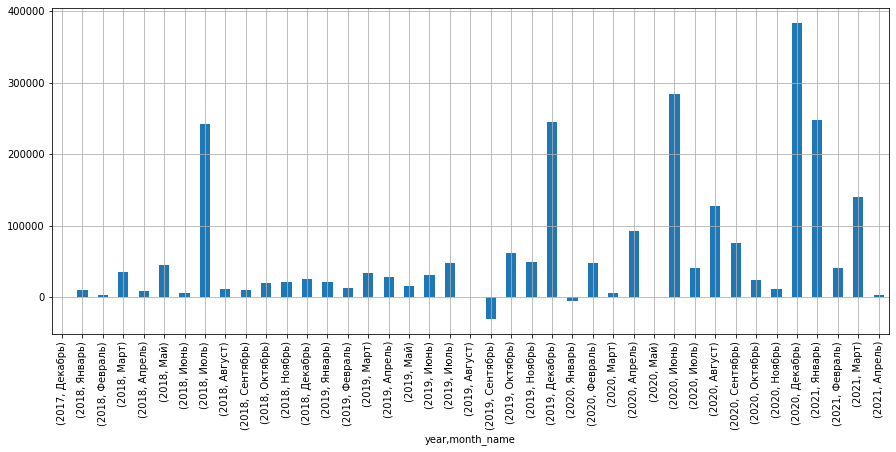

In [ ]:
sql_grouped = sql_grouped.set_index(['year', 'month_name'])
sql_grouped.plot.bar(figsize=(15,6), legend=None, grid=True)

1.3. Строим отчет по сумме пополнений (payment) с группировкой годам и партнерам. Высчитываем процент от суммы пополнений по каждому клиенту к общей выручке за этот год

In [ ]:
sql_billing = pd.read_sql("""SELECT 
                                  CAST (EXTRACT(YEAR FROM datetime) AS INT) AS Year,
                                  COALESCE (CAST (test_task_partner_acc.partnerid AS TEXT), 'Неизвестный партнер')  as Partner,
                                  CAST (SUM (transaction) AS INT) AS transaction_sum,
                                  SUM (transaction) / MAX(gross_year) * 100 AS year_percent
                            FROM 
                                  test_task_billing 
                                  LEFT JOIN test_task_partner_acc 
                                  ON test_task_billing.accountid = test_task_partner_acc.accountid
                                  LEFT JOIN (SELECT 
                                                  CAST (EXTRACT(YEAR FROM datetime) AS INT) AS date_part, 
                                                  CAST (SUM (transaction) AS INT) AS gross_year 
                                            FROM test_task_billing 
                                            GROUP BY EXTRACT(YEAR FROM datetime)) AS year_total
                                  ON EXTRACT(YEAR FROM test_task_billing.datetime) = date_part
                            WHERE
                                  object = 'payment'
                            GROUP BY
                                  EXTRACT(YEAR FROM datetime),
                                  test_task_partner_acc.partnerid
                            ORDER BY
                                  EXTRACT(YEAR FROM datetime),
                                  test_task_partner_acc.partnerid""",connection)
sql_billing

,year,partner,transaction_sum,year_percent
0,2018,11195,294,0.07
1,2018,12249,938,0.22
2,2018,12563,65,0.01
3,2018,14219,600,0.14
4,2018,15326,300,0.07
...,...,...,...,...
1680,2021,99569,864,0.20
1681,2021,99752,24,0.01
1682,2021,99762,9660,2.23
1683,2021,99945,2280,0.53


<p>По партнерам, отсутствующим в таблице test_task_partner_acc, процент от суммы пополнений получился больше 100% в связи с тем, что общая выручка за год будет меньше суммы пополнений за год, так как общая выручка уменьшается отрицательными транзакциями. Пополнения всегда положительные.</p>
<p>Возможно, следует скорректировать метрику, но в рамках тестового задания задание было выполнено буквально.</p>
<p>Для удобства восприятия отчет лучше представить в виде сводной таблицы. В связи с тем что в SQL отсутсвует удобный инструмент для построения соводной таблицы, сводная таблица была построена средствами PANDAS. Данные из БД передаются в PANDAS в сгруппированном виде, поэтому канал передачи данных не будет узким местом.</p>

In [ ]:
pd.pivot_table(sql_billing,
               index=["partner"],
               values=["transaction_sum", "year_percent"],
               columns=["year"],
               aggfunc='sum',
               fill_value=0,
               margins=True)

transaction_sum                    ... year_percent               
year                           2018     2019     2020  ...         2020   2021     All
partner                                                ...                            
10041                             0        0     1735  ...         0.16   0.20    0.36
10077                             0        0     1934  ...         0.18   0.42    0.59
10212                             0        0     4493  ...         0.41   0.43    0.85
10457                             0      108        0  ...         0.00   0.00    0.02
10564                             0        0     2129  ...         0.20   0.16    0.36
...                             ...      ...      ...  ...          ...    ...     ...
99752                             0        0     4422  ...         0.41   0.01    0.41
99762                             0        0    11664  ...         1.07   2.23    3.31
99945                             0        0      978  ...         0.09   0.53    0.62
Неизвестный партнер          162293  1095315  5064420  ...       466.73 485.72 1203.08
All                          190903  1567727  9041182  ...       833.23 864.49 2046.95

[874 rows x 10 columns]

<h2>2. Решение на Pandas</h2>
2.1. Объединяем таблицы test_task_billing и test_task_partner_acc и выводим на экран

In [ ]:
df_billing = pd.read_sql("""SELECT 
                                  CAST (test_task_billing.accountid AS INT) AS accountid_billing,
                                  datetime,
                                  object,
                                  transaction,
                                  test_task_partner_acc.accountid AS accountid_partner,
                                  CAST (test_task_partner_acc.partnerid AS INT)
                            FROM 
                                  test_task_billing 
                            LEFT JOIN 
                                  test_task_partner_acc 
                            ON test_task_billing.accountid=test_task_partner_acc.accountid""",connection)
df_billing

,accountid_billing,datetime,object,transaction,accountid_partner,partnerid
0,55733,2019-10-08 00:01:00,channel,-4.80,nan,nan
1,28036,2019-10-08 00:01:00,channel,-4.80,nan,nan
2,60490,2019-10-08 00:01:00,channel,-4.80,nan,nan
3,81206,2019-10-08 00:01:00,channel,-4.80,nan,nan
4,36021,2019-10-08 00:01:00,channel,-4.80,36021.00,13008.00
...,...,...,...,...,...,...
798777,94506,2019-10-08 00:01:00,channel,-4.80,nan,nan
798778,71667,2019-10-08 00:01:00,channel,-4.80,nan,nan
798779,69651,2019-10-08 00:01:00,channel,-4.80,69651.00,59597.00
798780,28434,2019-10-08 00:01:00,channel,-4.80,nan,nan


Существенное количество партнеров из таблицы с транзакциями отсутствует в таблице с партнерами. Посчитаем количество отсутствующих партнеров. Заменяем отсутствующих партнеров на "Неизвестный партнер"

In [ ]:
df_billing.loc[df_billing.partnerid.notnull()]

df_no_partner = df_billing.loc[df_billing.partnerid.isnull()]

print("Количество отсутствующих партнеров - ", len(df_no_partner.accountid_billing.unique()))
df_billing.fillna(value='Неизвестный партнер', inplace=True)

Количество отсутствующих партнеров -  14821


Создаем отдельные столбцы с месяцем и годом

In [ ]:
df_billing['year'] = df_billing['datetime'].dt.year
df_billing['month'] = df_billing['datetime'].dt.month
my_mnth_names = {1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 5: 'Май', 6: 'Июнь', 7: 'Июль', 8: 'Август', 9: 'Сентябрь', 10: 'Октбярь', 11: 'Ноябрь', 12: 'Декабрь'}
df_billing['month_names'] = df_billing.month.map(lambda p: my_mnth_names[p])


Считаем выручку по месяцам

In [ ]:
df_billing_grouped_mnth = df_billing.groupby(by=['year', 'month', 'month_names'])['transaction'].sum()
df_billing_grouped_mnth = df_billing_grouped_mnth.reset_index()[['year', 'month_names', 'transaction']].set_index(['year', 'month_names'])
df_billing_grouped_mnth
pd.pivot_table(df_billing,
               index=["year"],
               values=["transaction"],
               columns=['month', "month_names"],
               aggfunc='sum',
               fill_value=0,
               margins=True)

transaction                      ...                              
month                 1         2         3  ...       11        12        All
month_names      Январь   Февраль      Март  ...   Ноябрь   Декабрь           
year                                         ...                              
2017               0.00      0.00      0.00  ...     0.00    432.00     432.00
2018            9678.74   2435.50  35218.58  ... 20948.16  25565.04  435542.11
2019           20907.96  13244.40  32975.45  ... 48477.00 245374.90  513343.99
2020           -6040.25  47069.45   6084.36  ... 11370.10 383820.96 1085078.06
2021          248076.67  41310.36 139748.09  ...     0.00      0.00  432470.76
All           272623.13 104059.70 214026.48  ... 80795.26 655192.90 2466866.93

[6 rows x 13 columns]

2.2. Строим график выручки по месяцам

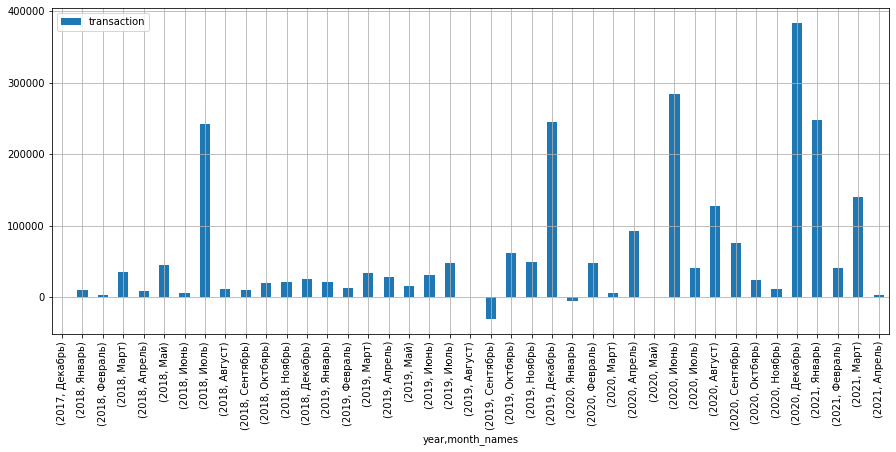

In [ ]:
df_billing_grouped_mnth.plot.bar(figsize=(15,6), grid=True)


2.3. Строим сводную таблицу по клиентам и годам

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
df_billing_grouped_year = df_billing.groupby(by=['year'])['transaction'].sum()

def year_total_perc(row):
  return row['transaction'] / df_billing_grouped_year[row.year] * 100

df_billing_payments = df_billing[df_billing['object'] == 'payment']
df_billing_payments['year_total_perc, %'] = df_billing_payments.apply(year_total_perc, axis='columns')

pd.pivot_table(df_billing_payments,
               index=["partnerid"],
               values=["transaction", "year_total_perc, %"],
               columns=["year"],
               aggfunc='sum',
               fill_value=0,
               margins=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


transaction                        ... year_total_perc, %               
year                       2018       2019       2020  ...               2020   2021     All
partnerid                                              ...                                  
10041.0                    0.00       0.00    1735.20  ...               0.16   0.20    0.36
10077.0                    0.00       0.00    1934.40  ...               0.18   0.42    0.59
10212.0                    0.00       0.00    4492.80  ...               0.41   0.43    0.85
10457.0                    0.00     108.00       0.00  ...               0.00   0.00    0.02
10564.0                    0.00       0.00    2128.80  ...               0.20   0.16    0.36
...                         ...        ...        ...  ...                ...    ...     ...
99752.0                    0.00       0.00    4422.00  ...               0.41   0.01    0.41
99762.0                    0.00       0.00   11664.00  ...               1.07   2.23    3.31
99945.0                    0.00       0.00     978.00  ...               0.09   0.53    0.62
Неизвестный партнер   162293.30 1095314.64 5064420.17  ...             466.73 485.72 1203.08
All                   190903.66 1567731.05 9041183.06  ...             833.23 864.49 2046.95

[874 rows x 10 columns]

По партнерам, отсутствующим в таблице test_task_partner_acc, процент от суммы пополнений получился больше 100% в связи с тем, что общая выручка за год будет меньше суммы пополнений за год, так как общая выручка уменьшается отрицательными транзакциями. Пополнения всегда положительные.

Возможно, следует скорректировать метрику, но в рамках тестового задания задание было выполнено буквально.